# Import Required libraries

In [46]:
# Import Basic Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import warnings
warnings.filterwarnings("ignore")

# sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             confusion_matrix)

# tensorflow packages
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Rescaling,
    Dense,
    Conv2D, 
    MaxPooling2D, 
    BatchNormalization, 
    Flatten
)
from tensorflow.keras.optimizers import (
    Adam, 
    RMSprop
)
from tensorflow.keras.losses import (
    SparseCategoricalCrossentropy, 
    CategoricalCrossentropy
)
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint
)

# UDFs

In [71]:
def generate_predictions(model, data_generator):
    """
        Generate Predictions and Results

        Args: 
            model : model that is trained
            data_generator : Training, Testing and Validation Dataset
                             Holds both the information 
    """

    predictions = model.predict(data_generator, verbose = 0)
    predictions = np.argmax(predictions, axis = 1)

    # Confusion Matrix
    print(classification_report(data_generator.classes,predictions))
    print(confusion_matrix(data_generator.classes, predictions))

    return predictions

# Load the Dataset

In [47]:
IMAGE_DIR = "/Users/kavisanthoshkumar/Downloads/Sheep_Classification_Images/"
CSV_PATH = "/Users/kavisanthoshkumar/Downloads/Sheep_Classification_Images/train_labels.csv"

In [48]:
#### Read the CSV file using pandas
label_dataset = pd.read_csv(CSV_PATH)

#### Encode the values of the label
le = LabelEncoder()
le.fit(label_dataset["label"].values)
label_dataset["label_Encoded"] = le.transform(label_dataset["label"])

#### Build the full Image Paths
label_dataset["filepath"] = label_dataset["filename"].apply(lambda x : os.path.join(IMAGE_DIR, x))

label_dataset.head(5)

,filename,label,label_Encoded,filepath
0,39d30b68.jpg,Naeimi,3,/Users/kavisanthoshkumar/Downloads/Sheep_Class...
1,4a9853bd.jpg,Goat,1,/Users/kavisanthoshkumar/Downloads/Sheep_Class...
2,d88facaa.jpg,Roman,5,/Users/kavisanthoshkumar/Downloads/Sheep_Class...
3,a3f4f4af.jpg,Roman,5,/Users/kavisanthoshkumar/Downloads/Sheep_Class...
4,16b31730.jpg,Naeimi,3,/Users/kavisanthoshkumar/Downloads/Sheep_Class...


In [49]:
pd.DataFrame({"labels":le.classes_, "Encoded_labels":le.transform(le.classes_)})

,labels,Encoded_labels
0,Barbari,0
1,Goat,1
2,Harri,2
3,Naeimi,3
4,Najdi,4
5,Roman,5
6,Sawakni,6


# Split the dataset into train and validation

In [50]:
X_train, X_val = train_test_split(label_dataset, 
                 train_size = 0.80, 
                 stratify= label_dataset['label']) 
# when we specify the stratify using class labels, then it gets split into stratified fashion

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")

Shape of X_train: (545, 4)
Shape of X_val: (137, 4)


In [51]:
X_test = pd.DataFrame({"filename": os.listdir(IMAGE_DIR+"test/")})
print(f"Shape of X_test: {X_test.shape}")

Shape of X_test: (144, 1)


# ImageData Generator

#### 1. TrainDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 20, 
    width_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.12, 
    horizontal_flip = True, 
    vertical_flip = True
)

# flow from dataframe 
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    directory = IMAGE_DIR+str("train/"),
    x_col = "filename",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = 32
)

Found 545 validated image filenames belonging to 7 classes.


#### 2. ValidationDataGenerator

In [53]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = IMAGE_DIR+"train/",
    x_col = "filename",
    y_col = "label",
    class_model = "categorical",
    target_size = (224, 224),
    batch_size = 32,
)

Found 137 validated image filenames belonging to 7 classes.


#### 3. TestDataGenerator

In [54]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    directory = IMAGE_DIR + "test/",
    x_col = "filename",
    y_col = None,
    class_mode = None,
    target_size = (224, 224),
    batch_size = 32
)

Found 144 validated image filenames.


# Xception - Transfer Learning Approach

In [14]:
xception_model = Xception(
    include_top = False,
    weights = None, 
    classes = 7,
    classifier_activation="softmax",
)

In [34]:
class PreTrainedModel(Model):

    def __init__(self, num_classes):
        super(PreTrainedModel, self).__init__()
        # xception model
        self.base_model = xception_model

        # Dense layer
        self.dense_layer_1 = Dense(units = 128, activation ="leaky_relu")
        self.dense_layer_2 = Dense(units = 64, activation ="leaky_relu")
        # Flatten
        self.flatten = Flatten()

        # Output layer 
        self.out = Dense(units = num_classes, activation ="softmax")

    def call(self, inputs):
        x = self.base_model(inputs)
        
        x = self.flatten(x) # flatten layer
        
        x = self.dense_layer_1(x) # Dense layer 1
        x = self.dense_layer_2(x) # Dense layer 2

        return self.out(x)
    
pre_trained_model = PreTrainedModel(num_classes=7)


#### Compile Model

In [35]:
pre_trained_model.compile(optimizer= Adam(), 
                        loss = CategoricalCrossentropy(),
                        metrics = ['f1_score'],
                        )

#### Callbacks

In [36]:
earlystopping_callback = EarlyStopping(
    monitor = "val_loss",
    patience = 5, 
    mode = "min",
    restore_best_weights = True, 
    verbose = 1
)

model_check_point_callback = ModelCheckpoint(
    filepath = "./artifacts/pre_trained_model.keras",
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, 
)

callbacks = [earlystopping_callback, model_check_point_callback]

#### Model Training

In [38]:
history = pre_trained_model.fit(train_generator, 
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = callbacks)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 796ms/step - f1_score: 0.1844 - loss: 1.6197 - val_f1_score: 0.1852 - val_loss: 1.4768
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 744ms/step - f1_score: 0.1419 - loss: 1.7061 - val_f1_score: 0.1830 - val_loss: 1.5118
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 802ms/step - f1_score: 0.1902 - loss: 1.7173 - val_f1_score: 0.2336 - val_loss: 1.4365
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 721ms/step - f1_score: 0.2213 - loss: 1.4813 - val_f1_score: 0.2219 - val_loss: 1.5145
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 741ms/step - f1_score: 0.1915 - loss: 1.5494 - val_f1_score: 0.2509 - val_loss: 1.5292
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 762ms/step - f1_score: 0.2181 - loss: 1.4385 - val_f1_score: 0.2205 - val_loss: 1.5398
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 759ms/step - f1_score: 0.2081 - loss: 1.5613 - val_f1_score: 0.3056 - val_loss: 1.3724
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 733ms/step - f1_score: 0.2890 - loss: 1.4328 - val_f1_s

In [39]:
pre_trained_model.summary()

Model: "pre_trained_model_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, None, None,     │    20,861,480 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,037,071 (385.43 MB)

 Trainable params: 33,660,847 (128.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 67,321,696 (256.81 MB)

#### Model loss

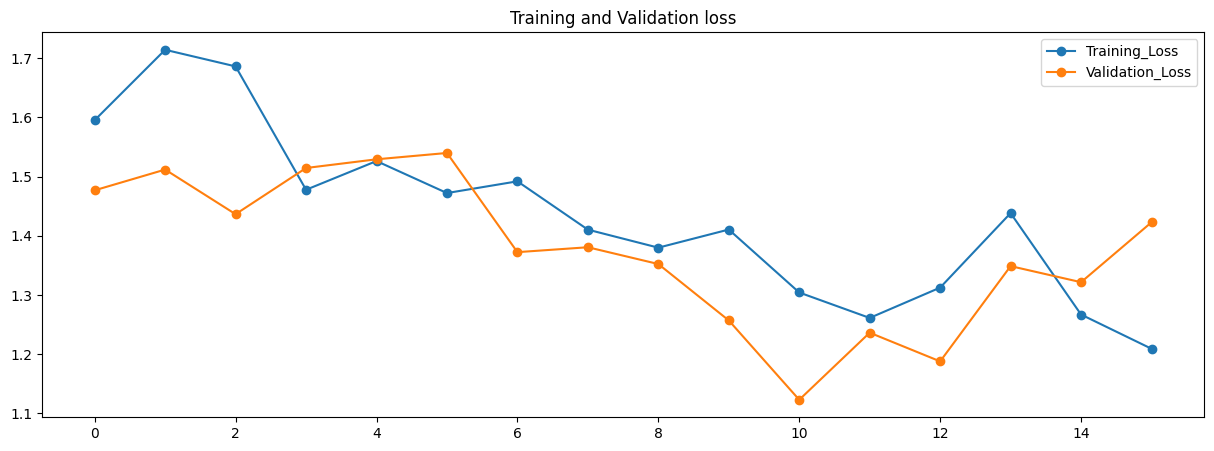

In [40]:
plt.figure(figsize= (15, 5))
plt.plot(history.history["loss"], 'o-',label = "Training_Loss")
plt.plot(history.history["val_loss"], 'o-',label = "Validation_Loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

#### Predictions

In [41]:
# Generating Predictions 
predictions = pre_trained_model.predict(test_generator, verbose = 0)
predictions = np.argmax(predictions, axis = 1)

# Submission format
X_test["label"] = predictions
class_indices = {v:k for k, v in train_generator.class_indices.items()}
X_test["label"] = X_test["label"].map(class_indices)

In [43]:
X_test.to_csv("./data/output/Submission_PreTrained_Xception.csv",index = False)

# Xception - Using Pre-Trained Weights & Retaining & Freezing the Weights

In [ ]:
xception_model = Xception(
    include_top = False,
    weights = "imagenet", 
    classes = 7,
    classifier_activation="softmax",
)

# Retaining & Freezing the Weights
for layer in xception_model.layers:
    layer.trainable = False

In [58]:
class PreTrainedModel(Model):

    def __init__(self, num_classes):
        super(PreTrainedModel, self).__init__()
        # xception model
        self.base_model = xception_model

        # Dense layer
        self.dense_layer_1 = Dense(units = 128, activation ="leaky_relu")
        self.dense_layer_2 = Dense(units = 64, activation ="leaky_relu")
        # Flatten
        self.flatten = Flatten()

        # Output layer 
        self.out = Dense(units = num_classes, activation ="softmax")

    def call(self, inputs):
        x = self.base_model(inputs)
        
        x = self.flatten(x) # flatten layer
        
        x = self.dense_layer_1(x) # Dense layer 1
        x = self.dense_layer_2(x) # Dense layer 2

        return self.out(x)
    
pre_trained_model_retain_wts = PreTrainedModel(num_classes=7)


#### Compile Model

In [59]:
pre_trained_model_retain_wts.compile(optimizer= Adam(), 
                        loss = CategoricalCrossentropy(),
                        metrics = ['accuracy'],
                        )

#### Callbacks

In [61]:
earlystopping_callback = EarlyStopping(
    monitor = "val_loss",
    patience = 20, 
    mode = "min",
    restore_best_weights = True, 
    verbose = 1
)

model_check_point_callback = ModelCheckpoint(
    filepath = "./artifacts/pre_trained_model.keras",
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, 
)

callbacks = [earlystopping_callback, model_check_point_callback]

#### Model Training

In [62]:
history = pre_trained_model_retain_wts.fit(train_generator, 
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = callbacks)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - accuracy: 0.4926 - loss: 44.9831 - val_accuracy: 0.4672 - val_loss: 42.5292
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.4262 - loss: 61.4953 - val_accuracy: 0.4891 - val_loss: 37.9305
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.4902 - loss: 43.7830 - val_accuracy: 0.4599 - val_loss: 62.1927
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.4164 - loss: 87.6669 - val_accuracy: 0.4964 - val_loss: 36.7116
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.5103 - loss: 36.4527 - val_accuracy: 0.5620 - val_loss: 23.5055
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.5463 - loss: 24.6966 - val_accuracy: 0.5255 - val_loss: 27.1376
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.4361 - loss: 28.5869 - val_accuracy: 0.3723 - val_loss: 39.7760
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.3842 - loss: 34.8574 - v

In [63]:
pre_trained_model_retain_wts.summary()

Model: "pre_trained_model_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, None, None,     │    20,861,480 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,423,167 (226.68 MB)

 Trainable params: 12,853,895 (49.03 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 25,707,792 (98.07 MB)

#### Model loss

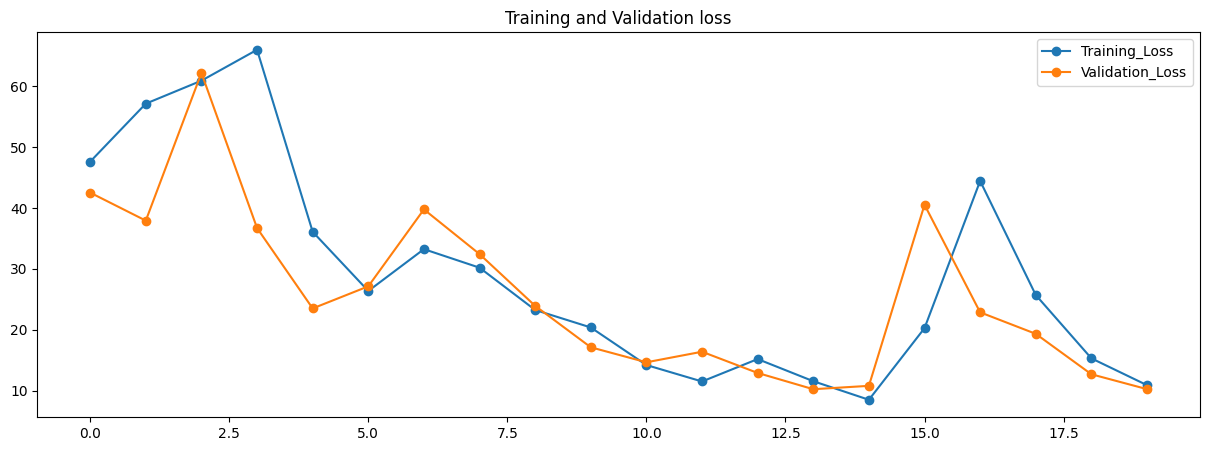

In [64]:
plt.figure(figsize= (15, 5))
plt.plot(history.history["loss"], 'o-',label = "Training_Loss")
plt.plot(history.history["val_loss"], 'o-',label = "Validation_Loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

# Predictions

In [72]:
predictions = generate_predictions(pre_trained_model_retain_wts, train_generator)

              precision    recall  f1-score   support

           0       0.03      0.04      0.03        28
           1       0.20      0.35      0.26        85
           2       0.15      0.16      0.16        50
           3       0.41      0.41      0.41       204
           4       0.06      0.04      0.04        57
           5       0.08      0.04      0.05        57
           6       0.02      0.02      0.02        64

    accuracy                           0.23       545
   macro avg       0.14      0.15      0.14       545
weighted avg       0.22      0.23      0.22       545

[[ 1  9  3  8  3  0  4]
 [ 6 30  6 26  9  4  4]
 [ 2 10  8 18  2  5  5]
 [15 46 20 84 11 11 17]
 [ 2 14  4 27  2  1  7]
 [ 8 21  5 12  5  2  4]
 [ 3 20  7 28  4  1  1]]


In [ ]:
# Generating Predictions 
predictions = pre_trained_model.predict(test_generator, verbose = 0)
predictions = np.argmax(predictions, axis = 1)

# Submission format
X_test["label"] = predictions
class_indices = {v:k for k, v in train_generator.class_indices.items()}
X_test["label"] = X_test["label"].map(class_indices)

In [ ]:
X_test.to_csv("./data/output/Submission_PreTrained_Xception.csv",index = False)